## COLAB TOOLS

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os
import sys

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "Colab Notebooks/prj_neuroread_analysis/neuroread/"
GOOGLE_DRIVE_PATH = os.path.join("/content", "drive", "MyDrive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)
os.chdir(GOOGLE_DRIVE_PATH)

# Install unavailable packages
import pip
def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        pip.main(['install', package])

import_or_install("mne")


['.git', '.DS_Store', '.gitignore', 'EEG', 'LICENSE', 'README.md', 'train_cl_eeg2speech_2.ipynb', 'train_cl_eeg2speech_rochester_subj_2.ipynb', 'train_cl_eeg2speech_rochester_v1.ipynb', 'train_eeg2speech_rochester.ipynb', 'train_cl_eeg2speech_rochester_v2.ipynb', 'train_cl_eeg2speech_rochester_v3.ipynb']


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Collecting mne

Downloading mne-1.3.1-py3-none-any.whl (7.6 MB)

Output()

Requirement already satisfied: pooch>=1.5 in /usr/local/lib/python3.8/dist-packages (from mne) (1.6.0)

Requirement already satisfied: numpy>=1.15.4 in /usr/local/lib/python3.8/dist-packages (from mne) (1.22.4)

Requirement already satisfied: jinja2 in /usr/local/lib/python3.8/dist-packages (from mne) (2.11.3)

Requirement already satisfied: matplotlib in /usr/local/lib/python3.8/dist-packages (from mne) (3.5.3)

Requirement already satisfied: packaging in /usr/local/lib/python3.8/dist-packages (from mne) (23.0)

Requirement already satisfied: scipy>=1.1.0 in /usr/local/lib/python3.8/dist-packages (from mne) (1.7.3)

Requirement already satisfied: decorator in /usr/local/lib/python3.8/dist-packages (from mne) (4.4.2)

Requirement already satisfied: tqdm in /usr/local/lib/python3.8/dist-packages (from mne) (4.64.1)

Requirement already satisfied: requests>=2.19.0 in /usr/local/lib/python3.8/dist-packages (from pooch>=1.5->mne) (2.25.1)

Requirement already satisfied: appdirs>=1.3.0 in /usr/local/lib/python3.8/dist-packages (from pooch>=1.5->mne) (1.4.4)

Requirement already satisfied: MarkupSafe>=0.23 in /usr/local/lib/python3.8/dist-packages (from jinja2->mne) (2.0.1)

Requirement already satisfied: fonttools>=4.22.0 in /usr/local/lib/python3.8/dist-packages (from matplotlib->mne) (4.38.0)

Requirement already satisfied: pyparsing>=2.2.1 in /usr/local/lib/python3.8/dist-packages (from matplotlib->mne) (3.0.9)

Requirement already satisfied: python-dateutil>=2.7 in /usr/local/lib/python3.8/dist-packages (from matplotlib->mne) (2.8.2)

Requirement already satisfied: pillow>=6.2.0 in /usr/local/lib/python3.8/dist-packages (from matplotlib->mne) (8.4.0)

Requirement already satisfied: cycler>=0.10 in /usr/local/lib/python3.8/dist-packages (from matplotlib->mne) (0.11.0)

Requirement already satisfied: kiwisolver>=1.0.1 in /usr/local/lib/python3.8/dist-packages (from matplotlib->mne) (1.4.4)

Requirement already satisfied: six>=1.5 in /usr/local/lib/python3.8/dist-packages (from python-dateutil>=2.7->matplotlib->mne) (1.15.0)

Requirement already satisfied: idna<3,>=2.5 in /usr/local/lib/python3.8/dist-packages (from requests>=2.19.0->pooch>=1.5->mne) (2.10)

Requirement already satisfied: chardet<5,>=3.0.2 in /usr/local/lib/python3.8/dist-packages (from requests>=2.19.0->pooch>=1.5->mne) (4.0.0)

Requirement already satisfied: urllib3<1.27,>=1.21.1 in /usr/local/lib/python3.8/dist-packages (from requests>=2.19.0->pooch>=1.5->mne) (1.24.3)

Requirement already satisfied: certifi>=2017.4.17 in /usr/local/lib/python3.8/dist-packages (from requests>=2.19.0->pooch>=1.5->mne) (2022.12.7)

Installing collected packages: mne

Successfully installed mne-1.3.1

In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
 print('Not connected to a GPU')
else:
 print(gpu_info)

Your runtime has 17.2 gigabytes of available RAM

zsh:1: command not found: nvidia-smi


## Main code

In [1]:
import os, sys, glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import numpy as np

import mne

import matplotlib
import matplotlib.pyplot as plt

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
def eval_model_cl(dl, model, device=torch.device('cpu'), verbose=True):
    """ 
    This function calculates the loss on data, setting backward gradients and batchnorm
    off. This function is written for contrasting learning where the model takes in two
    inputs.

    Args:

    Returns:
      loss_test: Mean loss of all test samples (scalar)

    """
    losses, losses_X1, losses_X2 = [], [], []
    model.to(device)  # inplace for model
    # Set the model in evaluation mode
    model.eval()

    with torch.no_grad():
        for idx_batch, (X1b, X2b) in enumerate(dl):

            X1b = X1b.to(device)
            X2b = X2b.to(device)

            X1b_features, X2b_features, logit_sc = model(X1b, X2b)

            # Normalize features
            X1b_f_n = X1b_features / X1b_features.norm(dim=1, keepdim=True)
            X2b_f_n = X2b_features / X2b_features.norm(dim=1, keepdim=True)

            logits_per_X1 = logit_sc * X1b_f_n @ X2b_f_n.t()
            logits_per_X2 = logits_per_X1.t()

            # Number of labels equals to the 1st dimension of X1b
            labels = torch.arange(X1b.shape[0], device=device)

            # Batch Loss 
            loss_X1 = F.cross_entropy(logits_per_X1, labels)
            loss_X2 = F.cross_entropy(logits_per_X2, labels)
            loss_batch   = (loss_X1 + loss_X2) / 2
            losses.append(loss_batch.item())
            losses_X1.append(loss_X1.item())
            losses_X2.append(loss_X2.item())

        # Epoch loss (mean of batch losses)
        loss  = sum(losses) / len(losses)
        loss_X1 = sum(losses_X1) / len(losses_X1)
        loss_X2 = sum(losses_X2) / len(losses_X2)

        if verbose:
          print(f"====> Validation loss: {loss:.4f},  X1 loss: {loss_X1:.4f}   X2 loss: {loss_X2:.4f}")

        return loss, loss_X1, loss_X2


In [3]:
def unfold_raw(raw, window_size=None, stride=None):
    """
    This function unfolds raw MNE object into a list of raw objects
    Args:
        raw: a raw MNE object cropped by rejecting bad segments.
    Returns:
        raw_unfolded: a raw MNE object unfolded by applying a sliding window.
    """
    if window_size is None:
        window_size = int(5 * raw.info['sfreq'])
    if stride is None:
        stride = window_size
    nchans = len(raw.ch_names)
    sig = torch.tensor(raw.get_data(), dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    sig_unf = F.unfold(sig, (nchans, window_size), stride=stride , padding=0)
    sig_unf = sig_unf.permute(0, 2, 1).reshape(-1, sig_unf.shape[-1], nchans, window_size)
    return sig_unf

In [4]:
def rm_repeated_annotations(raw):
    """This functions taskes in raw MNE obejct and removes repeated annotations"""
    annots = raw.annotations.copy()
    annots_drop = []
    for k in annots:
        annots_drop.extend([k for kk in annots if (k['onset'] > kk['onset']) and (k['onset']+k['duration'] < kk['onset']+kk['duration']) ])

    annots_updated = [i for i in annots if i not in annots_drop]
    onsets = [i['onset'] for i in annots_updated]
    durations = [i['duration'] for i in annots_updated]
    descriptions = [i['description'] for i in annots_updated]
    print('Initial num of annots: %d  Num of removed annots: %d  Num of retained annots:  %d' % (len(annots), len(annots_drop), len(annots_updated)))
    print(f' New annots: {annots_updated}')
    raw.set_annotations(mne.Annotations(onsets, durations, descriptions) ) 
    return raw

## Read Data

In [5]:
subj_ids = [3]
fs = 128
window_size = int(5 * fs)
stride_size_train, stride_size_val, stride_size_test = int(2.5 * fs), int(5 * fs), int(5 * fs)
n_channs = 129 # 128 for eeg, 1 for env
batch_size = int(32)
print('-------------------------------------')
print(f'window_size: {window_size}  stride_size_test: {stride_size_test}')

dataset_name = ['rochester_data', 'natural_speech']
outputs_path = f'../outputs/'
data_path = os.path.join(outputs_path, dataset_name[0], dataset_name[1])
print(f'data_path: {data_path}')

-------------------------------------
window_size: 640  stride_size_test: 640
data_path: ../outputs/rochester_data/natural_speech


In [6]:
raws_train_windowed, raws_val_windowed, raws_test_windowed = [], [], []

for subj_id in subj_ids:
    subj_path = os.path.join(data_path, f'subj_{subj_id}')

    # load subject raw MNE object
    raw = mne.io.read_raw(os.path.join(subj_path, 'after_ica_raw.fif'), preload=True)
    # drop M1 and M2 channels
    raw.drop_channels(['M1', 'M2'])
    assert raw.info['nchan'] == n_channs

    raw = rm_repeated_annotations(raw)
    annots = raw.annotations.copy()
    raw_split = [raw.copy().crop(t1, t2) for t1, t2 in zip(annots.onset[:-1]+annots.duration[:-1], annots.onset[1:])]

    # Pick the split with the longest duration for validation, supposedly less noisy
    ix_val = np.argmax([i.get_data().shape[1] for i in raw_split])
    raw_val = [raw_split.pop(ix_val)] # create a list to make it iterable. later may be used for multiple splits

    # Pick the next split with the longest duration for testing, supposedly less noisy
    ix_test = np.argmax([i.get_data().shape[1] for i in raw_split])
    raw_test = [raw_split.pop(ix_test)]
    
    # creat list of unfolded tensor raw objects
    fs = raw.info['sfreq']
    raws_train_windowed.extend([unfold_raw(i, window_size=window_size, stride=stride_size_train) for i in raw_split if i.get_data().shape[1] > window_size])
    raws_val_windowed.extend([unfold_raw(i, window_size=window_size, stride=stride_size_val) for i in raw_val if i.get_data().shape[1] > window_size])
    raws_test_windowed.extend([unfold_raw(i, window_size=window_size, stride=stride_size_test) for i in raw_test if i.get_data().shape[1] > window_size])
    print("-------------------------------------")
    print('N train: %d  N val: %d  N test: %d' % (len(raws_train_windowed), len(raws_val_windowed), len(raws_test_windowed)))

# concatenate all in second dimension
sigs_train = torch.cat(raws_train_windowed, dim=1).permute(1, 0, 2, 3)
sigs_val = torch.cat(raws_val_windowed, dim=1).permute(1, 0, 2, 3)
sigs_test = torch.cat(raws_test_windowed, dim=1).permute(1, 0, 2, 3)
print(f"Shape Trian: {sigs_train.shape}  Shape Val: {sigs_val.shape}  Shape Test: {sigs_test.shape}")

eegs_train = sigs_train[:, :, :-1, :]
eegs_val = sigs_val[:, :, :-1, :]
eegs_test = sigs_test[:, :, :-1, :]
print("-------------------------------------")
print(f"Shape EEG Train: {eegs_train.shape}  Val: {eegs_val.shape}  Test: {eegs_test.shape}")

# To avoid information leakage, we estimate the mean and std from the training set only.
mean_eeg_train =  eegs_train.mean()
std_eeg_train = eegs_train.std()
print(f"Mean: {mean_eeg_train}  Std: {std_eeg_train}")

envs_train = sigs_train[:, :, [-1], :]
envs_val = sigs_val[:, :, [-1], :]
envs_test = sigs_test[:, :, [-1], :]
print(f"Shape Env Train: {envs_train.shape}  Val: {envs_val.shape}  Test: {envs_test.shape}")

# Estimate mean and std of the Envelope data set
mean_env_train =  envs_train.mean()
std_env_train = envs_train.std()
print(f"Mean Env: {mean_env_train}  Std Env: {std_env_train}")

# Normalize the data
eegs_train = (eegs_train - mean_eeg_train) / std_eeg_train
eegs_val = (eegs_val - mean_eeg_train) / std_eeg_train
eegs_test = (eegs_test - mean_eeg_train) / std_eeg_train

envs_train = (envs_train - mean_env_train) / std_env_train
envs_val = (envs_val - mean_env_train) / std_env_train
envs_test = (envs_test - mean_env_train) / std_env_train



Opening raw data file ../outputs/rochester_data/natural_speech/subj_3/after_ica_raw.fif...
    Range : 0 ... 464571 =      0.000 ...  3629.461 secs
Ready.
Reading 0 ... 464571  =      0.000 ...  3629.461 secs...
Initial num of annots: 47  Num of removed annots: 19  Num of retained annots:  28
 New annots: [OrderedDict([('onset', 0.0), ('duration', 0.0), ('description', 'bad'), ('orig_time', None)]), OrderedDict([('onset', 43.135948), ('duration', 4.115089416503906), ('description', 'bad'), ('orig_time', None)]), OrderedDict([('onset', 121.796593), ('duration', 5.6010894775390625), ('description', 'bad'), ('orig_time', None)]), OrderedDict([('onset', 176.748077), ('duration', 1.760345458984375), ('description', 'bad'), ('orig_time', None)]), OrderedDict([('onset', 275.317291), ('duration', 2.994842529296875), ('description', 'bad'), ('orig_time', None)]), OrderedDict([('onset', 357.205322), ('duration', 2.126129150390625), ('description', 'bad'), ('orig_time', None)]), OrderedDict([('on

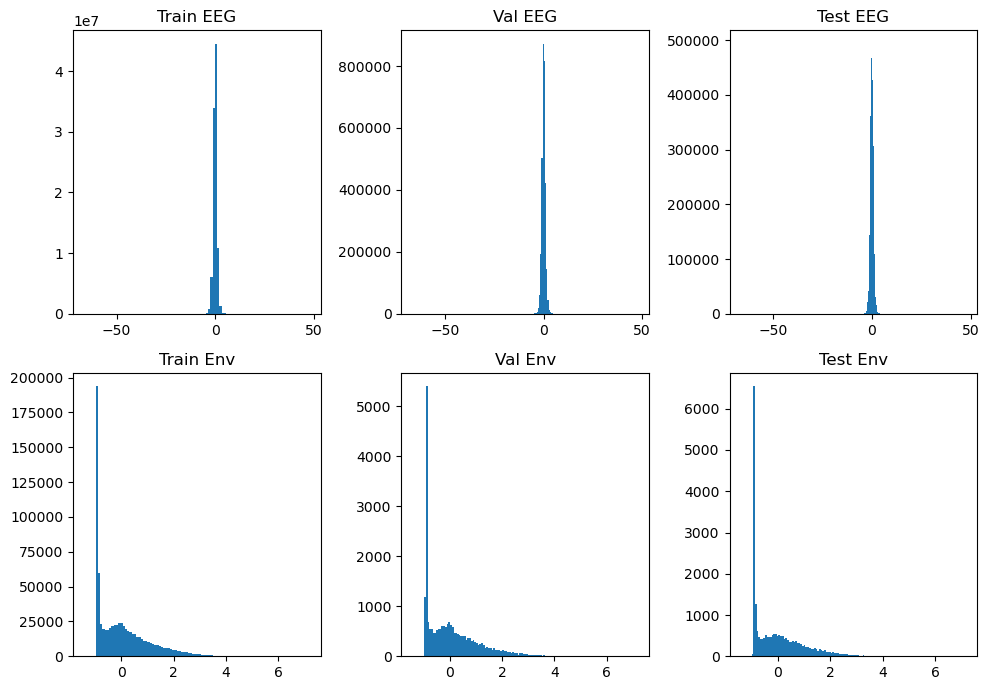

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(10, 7), sharex='row')
ax[0, 0].hist(eegs_train.flatten().numpy(), bins=100);
ax[0, 0].set_title('Train EEG')
ax[0, 1].hist(eegs_val.flatten().numpy(), bins=100);
ax[0, 1].set_title('Val EEG')
ax[0, 2].hist(eegs_test.flatten().numpy(), bins=100);
ax[0, 2].set_title('Test EEG')
ax[1, 0].hist(envs_train.flatten().numpy(), bins=100);
ax[1, 0].set_title('Train Env')
ax[1, 1].hist(envs_val.flatten().numpy(), bins=100);
ax[1, 1].set_title('Val Env')
ax[1, 2].hist(envs_test.flatten().numpy(), bins=100);
ax[1, 2].set_title('Test Env')
plt.tight_layout()
plt.show();

### Pytorch dataloader

In [8]:
class MyDataset(Dataset):
    def __init__(self, eeg, env):
        self.eeg = eeg
        self.env = env
    
    def __getitem__(self, index):
        return self.eeg[index], self.env[index]
    
    def __len__(self):
        return len(self.eeg)
    
dataset_train = MyDataset(eegs_train, envs_train)
dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)

dl_val = DataLoader(MyDataset(eegs_val, envs_val), batch_size=batch_size, shuffle=True, drop_last=True)

## Model

In [9]:
class Conv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, **kargs):
        super().__init__(in_channels, out_channels, kernel_size, **kargs)

    def __call__(self, inp):
        self.out = super().__call__(inp)

        if self.out.requires_grad:
            self.out.retain_grad()

        return self.out
    
    # -----------------------------------------------------------------------------------------------
class Flatten:
    
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  def parameters(self):
    return []
  
  # -----------------------------------------------------------------------------------------------
class Linear(nn.Linear):
    def __init__(self, x, y, **kargs):
        super().__init__(x, y, **kargs)

    def __call__(self, inp):
        self.out = super().__call__(inp)
        return self.out
  # -----------------------------------------------------------------------------------------------
   
class ELU(nn.ELU):
    def __init__(self, alpha=1.0, inplace=False):
        super().__init__(alpha=1.0, inplace=False)

    def __call__(self, inp):
        self.out = super().__call__(inp)
        if self.out.requires_grad:
            self.out.retain_grad()
        return self.out

  # -----------------------------------------------------------------------------------------------
class Sequential:
  
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

    def named_parameters(self):
        # get parameters of all layers and stretch them out into one list
        return ((n, p) for layer in self.layers for n, p in layer.named_parameters())

In [10]:
# My implementation of the shallow convnet

fs = 64 # sampling rate
T = 5 * fs # number of time points in each trial
C = 64 # number of EEG channels
F1 = 8 # number of channels (depth) in the first conv layer
D = 2 # number of spatial filters in the second conv layer
F2 = D * F1 # number of channels (depth) in the pont-wise conv layer
num_classes = 4 # number of classes

shallow_covnet = Sequential([
    Conv2d(1, 40, (1, int(fs//2)), padding='same', bias=True),
    Conv2d(40, 40, (C, 1), padding=(0, 0), bias=False), nn.BatchNorm2d(40, affine=True), 
    nn.AvgPool2d((1, 75), (1, 15)), nn.Dropout(0.5),
    Conv2d(40, 4, kernel_size=(1, 30), padding='same', stride=(1, 1), bias=True),
    nn.Flatten(1, -1), # Flatten start_dim=1, end_dim=-1
    Linear(62*4, 4, bias=True),
])



In [11]:

class EEGEncoder(nn.Module):
    def __init__(self,             
            fs = 128, # sampling rate
            T = 5, # lenght of each trial in seconds
            C = 128, # number of EEG channels
            F1 = 8, # 8 or 4 number of channels (depth) in the first conv layer
            D = 2, # number of spatial filters in the second conv layer
            F2 = None # number of channels (depth) in the pont-wise conv layer
        ):
        super(EEGEncoder, self).__init__()

        if F2 is None:
            F2 = D * F1

        self.eeg_encoder = nn.Sequential(
            Conv2d(1, F1, (1, int(fs/2)), padding='same', bias=True, groups=1),
            nn.BatchNorm2d(F1, affine=True),
            Conv2d(F1, out_channels=D*F1, kernel_size=(C, 1), padding=(0, 0), bias=False, groups=F1),
            nn.BatchNorm2d(D*F1, affine=True), ELU(), nn.AvgPool2d(1, 4), nn.Dropout(0.25),
                    
            Conv2d(F2, F2, (1, int(fs/(2*4))), padding='same', bias=False, groups=D*F1),
            Conv2d(D*F1, F2, kernel_size=(1, 1), padding=(0, 0), groups=1, bias=False),
            nn.BatchNorm2d(F2, affine=True), ELU(), nn.AvgPool2d(1, 8), nn.Dropout(0.25),

            nn.Flatten(),
            #nn.Linear(F2*int((T*fs)//(8*4)), int(fs/4))
        ) 

    def forward(self, x):
        x = self.eeg_encoder(x)
        return x


def normalize_weights_eegnet(eeg_encoder):

    for ix, (name, param) in enumerate(eeg_encoder.named_parameters()):
        if  name == 'weight' and param.ndim==4 and ix==1: # normalize conv weights to max norm 1
            param.data = torch.renorm(param.data, 2, 0, maxnorm=1)
            #param.data /=  eps + param.data.norm(2, dim=0, keepdim=True)
        elif name == 'weight' and param.ndim==2: # normalize fc weights to max norm 0.25
            param.data = torch.renorm(param.data, 2, 0, maxnorm=0.25)
            #param.data /=  eps + param.data.norm(2, dim=0, keepdim=True)

eeg_encoder = EEGEncoder()
eeg_encoder.eeg_encoder

# Test the model, add no grad
with torch.no_grad():
    print(eeg_encoder(eegs_train[:32, :, :, :]).shape)

torch.Size([32, 320])


/Users/keyvan.mahjoory/opt/anaconda3/envs/mne/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525699189/work/aten/src/ATen/native/Convolution.cpp:896.)
  return F.conv2d(input, weight, bias, self.stride,


In [12]:
class EnvEncoder(nn.Module):

    def __init__(self,             
            fs = 128, # sampling rate
            T = 5, # lenght of each trial in seconds
            F1 = 4
        ):
        super(EnvEncoder, self).__init__()

        self.env_encoder = nn.Sequential(
            Conv2d(1, F1, (1, int(fs//2)), padding='same', bias=True),
            nn.BatchNorm2d(F1, affine=True), ELU(), nn.AvgPool2d(1, 2), nn.Dropout(0.5),
            Conv2d(F1, F1, (1, int(fs//4)), padding='same', bias=False, groups=1),
            nn.BatchNorm2d(F1, affine=True), ELU(), nn.AvgPool2d(1, 2), nn.Dropout(0.5),
            Conv2d(F1, F1*4, (1, int(fs//8)), padding='same', bias=False, groups=1),
            nn.BatchNorm2d(F1*4, affine=True), ELU(), nn.AvgPool2d(1, 8), nn.Dropout(0.5),
            nn.Flatten(),
            #nn.Linear(F1*int((T*fs)//(2*8)), int(fs/4))
        ) 

    def forward(self, x):
        x = self.env_encoder(x)
        return x

env_encoder = EnvEncoder()
env_encoder.env_encoder

# Test the model, add no grad
with torch.no_grad():
    print(env_encoder(envs_train[:32, :, :, :]).shape)

torch.Size([32, 320])


import torch
import torch.nn as nn

from collections import OrderedDict

params = OrderedDict([
    ('fc0', nn.Linear(in_features=4,out_features=4)),
    ('ReLU0', nn.ReLU()),
    ('fc1L:final', nn.Linear(in_features=4,out_features=1))
])
mdl = nn.Sequential(params)

# throws error
# mdl['fc0']

for m in mdl.children():
    print(m)

print()

for m in mdl.modules():
    print(m)

print()

for name, m in mdl.named_modules():
    print(name)
    print(m)

print()

for name, m in mdl.named_children():
    print(name)
    print(m)

In [13]:
class CES(nn.Module):
    def __init__(self, 
                 eeg_encoder= eeg_encoder.eeg_encoder,
                 env_encoder = env_encoder.env_encoder): 
        super().__init__()

        self.eeg_encoder = eeg_encoder
        self.env_encoder = env_encoder
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    def encode_eeg(self, x):
        return self.eeg_encoder(x)
    
    def encode_env(self, x):
        return self.env_encoder(x)
    
    def forward(self, eeg, env):
        eeg_features = self.encode_eeg(eeg)
        env_features = self.encode_env(env)
        return eeg_features, env_features, self.logit_scale.exp()
  

model = CES();
model.to(device)
#for n,p in model.named_parameters():
    #print(n, p.shape)


CES(
  (eeg_encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=same)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(8, 16, kernel_size=(128, 1), stride=(1, 1), groups=8, bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=1, stride=4, padding=0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=same, groups=16, bias=False)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool2d(kernel_size=1, stride=8, padding=0)
    (12): Dropout(p=0.25, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (env_encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(1, 64), stride=(1, 1), pad

In [14]:
summary(eeg_encoder, (1, 128, 640))
summary(env_encoder, (1, 1, 640))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 640]             520
       BatchNorm2d-2          [-1, 8, 128, 640]              16
            Conv2d-3           [-1, 16, 1, 640]           2,048
       BatchNorm2d-4           [-1, 16, 1, 640]              32
               ELU-5           [-1, 16, 1, 640]               0
         AvgPool2d-6           [-1, 16, 1, 160]               0
           Dropout-7           [-1, 16, 1, 160]               0
            Conv2d-8           [-1, 16, 1, 160]             256
            Conv2d-9           [-1, 16, 1, 160]             256
      BatchNorm2d-10           [-1, 16, 1, 160]              32
              ELU-11           [-1, 16, 1, 160]               0
        AvgPool2d-12            [-1, 16, 1, 20]               0
          Dropout-13            [-1, 16, 1, 20]               0
          Flatten-14                  [

## Model Setup

## Optimization

In [15]:

with torch.no_grad():
    for ix, layer in enumerate(model.eeg_encoder + model.env_encoder):
        if isinstance(layer, nn.Conv2d):
            layer.weight *= 0.01
            if layer.bias is not None:
                layer.bias *= 0

        if isinstance(layer, nn.Linear):
          layer.weight *= 0.01
          if layer.bias is not None:
            layer.bias *=0


print(sum(p.nelement() for p in model.parameters())) # number of parameters in total
for p in model.parameters():
    p.requires_grad = True

print(model.eeg_encoder)
print(model.env_encoder)

lr = 0.001
optimizer_adamw = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
optimizer_nadam = optim.NAdam(model.parameters(), lr=lr)
optimizer = optimizer_nadam


5005
Sequential(
  (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=same)
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Conv2d(8, 16, kernel_size=(128, 1), stride=(1, 1), groups=8, bias=False)
  (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ELU(alpha=1.0)
  (5): AvgPool2d(kernel_size=1, stride=4, padding=0)
  (6): Dropout(p=0.25, inplace=False)
  (7): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=same, groups=16, bias=False)
  (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ELU(alpha=1.0)
  (11): AvgPool2d(kernel_size=1, stride=8, padding=0)
  (12): Dropout(p=0.25, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
)
Sequential(
  (0): Conv2d(1, 4, kernel_size=(1, 64), stride=(1, 1), padding=same)
  (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=T

In [16]:
print("---  Data specs:   ---")
print(f" Train Set: shape EEG: {dataloader.dataset.eeg.shape}   Env: {dataloader.dataset.env.shape}")
print(f" Val Set: shape EEG: {eegs_val.shape}   Env: {envs_val.shape}")
print()
print("---  Model specs:  ---")
print(f" Number of parameters: {sum(p.nelement() for p in model.parameters())}") # number of parameters in total
print()
print("---  Training specs:  ---")
print(f" Train set: Batch size: {dataloader.batch_size}")
print(f" Train set: number of batches: {len(dataloader)}")
print(f" Val set: Batch size: {dl_val.batch_size}")
print(f" Val set: number of batches: {len(dl_val)}")
print(f"Chance level loss for Train set: {torch.tensor(1/batch_size).log():.4f}")
print(f"Learning rate: {lr}")


---  Data specs:   ---
 Train Set: shape EEG: torch.Size([1197, 1, 128, 640])   Env: torch.Size([1197, 1, 1, 640])
 Val Set: shape EEG: torch.Size([38, 1, 128, 640])   Env: torch.Size([38, 1, 1, 640])

---  Model specs:  ---
 Number of parameters: 5005

---  Training specs:  ---
 Train set: Batch size: 32
 Train set: number of batches: 37
 Val set: Batch size: 32
 Val set: number of batches: 1
Chance level loss for Train set: -3.4657
Learning rate: 0.001


# gradient not getting updateing
maybe because the chain removes the referencing ...

links to check for implementing the loss function:  

https://www.kaggle.com/code/moeinshariatnia/openai-clip-simple-implementation/notebook  


https://github.com/openai/CLIP/issues/83


https://github.com/mlfoundations/open_clip

https://github.com/mlfoundations/open_clip/blob/main/src/open_clip/loss.py

In [17]:
sys.getsizeof(eegs_train.storage())/1e6

392.233008

In [18]:
num_train = eegs_train.shape[0]
lossi = []
udri = [] # update / data ratio 
ud = []

for epoch in range(1, 50):

    model.train()
    for ix_batch, (Xb_eeg, Xb_env) in enumerate(dataloader):

        # send to device
        Xb_eeg = Xb_eeg.to(device)
        Xb_env = Xb_env.to(device)

        # Zero out gradients
        optimizer.zero_grad()

        # forward pass
        eeg_features, env_features, logit_scale = model(Xb_eeg, Xb_env) 


        # normalize features
        eeg_features_n = eeg_features / eeg_features.norm(dim=1, keepdim=True)
        env_features_n = env_features / env_features.norm(dim=1, keepdim=True)

        # logits
        logits_per_eeg = logit_scale * eeg_features_n @ env_features_n.t()
        logits_per_env = logits_per_eeg.t()

        #loss function
        labels = torch.arange(batch_size).to(device)
        loss_eeg = F.cross_entropy(logits_per_eeg, labels)
        loss_env = F.cross_entropy(logits_per_env, labels)
        loss   = (loss_eeg + loss_env)/2

        # backward pass
        loss.backward()
        optimizer.step()


        # track stats
        if ix_batch % 10 == 0:
            print(f'Batch: {ix_batch:7d}: {loss.item():.4f}  {loss_eeg.item():.4f}  {loss_env.item():.4f}   {eeg_features.detach().std().item():.4f}  {env_features.detach().std().item():.4f}')
        lossi.append(loss.log10().item())

        with torch.no_grad():
            ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in model.parameters() ])
        
        #break   

    eval_model_cl(dl_val, model, device=device)
    
    # normalize weights
    with torch.no_grad():
      normalize_weights_eegnet(model.eeg_encoder)

    model.train()
            
    #break   


Batch:       0: 3.8956  3.8917  3.8994   0.0092  0.9938
Batch:      10: 3.6356  3.6339  3.6372   0.0623  1.1013
Batch:      20: 3.4092  3.4018  3.4165   0.1113  1.1032
Batch:      30: 3.7114  3.7093  3.7135   0.1505  1.1101
====> Validation loss: 3.4380,  X1 loss: 3.4616   X2 loss: 3.4145
Batch:       0: 3.3949  3.3932  3.3967   0.1812  1.1152
Batch:      10: 3.3685  3.3725  3.3644   0.2071  1.1272
Batch:      20: 3.6495  3.6513  3.6477   0.2446  1.1477
Batch:      30: 3.6070  3.6023  3.6116   0.2589  1.1265
====> Validation loss: 3.5161,  X1 loss: 3.5222   X2 loss: 3.5099
Batch:       0: 3.4336  3.4301  3.4371   0.2722  1.1337
Batch:      10: 3.6270  3.6166  3.6375   0.2948  1.1447
Batch:      20: 3.2118  3.2222  3.2015   0.2993  1.1458
Batch:      30: 3.4153  3.4169  3.4136   0.3183  1.1491
====> Validation loss: 3.4336,  X1 loss: 3.4524   X2 loss: 3.4148
Batch:       0: 3.3739  3.3706  3.3771   0.3177  1.1562
Batch:      10: 3.0435  3.0429  3.0442   0.3377  1.1462
Batch:      20: 2.

In [19]:
eegs_val.device, envs_val.device

(device(type='cpu'), device(type='cpu'))

layer 4 (       ELU):  mean  -0.009653, std 7.283012e-01, range [-9.997158e-01  5.332768e+00]
torch.Size([32, 16, 1, 640])
layer 10 (       ELU):  mean  +0.039738, std 6.279333e-01, range [-9.935709e-01  3.936317e+00]
torch.Size([32, 16, 1, 160])
layer 2 (       ELU):  mean  -0.151667, std 6.381824e-01, range [-9.985372e-01  5.939834e+00]
torch.Size([32, 4, 1, 640])
layer 7 (       ELU):  mean  +0.015353, std 7.629862e-01, range [-9.931317e-01  5.083470e+00]
torch.Size([32, 4, 1, 320])
layer 12 (       ELU):  mean  -0.000876, std 6.585112e-01, range [-9.887606e-01  3.645363e+00]
torch.Size([32, 16, 1, 160])


AttributeError: 'NoneType' object has no attribute 'mean'

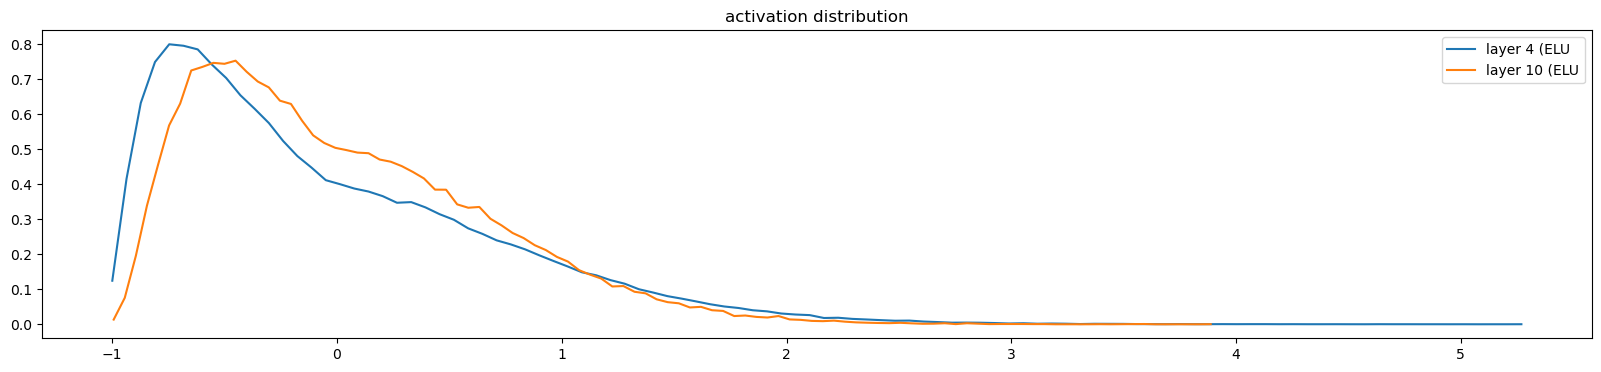

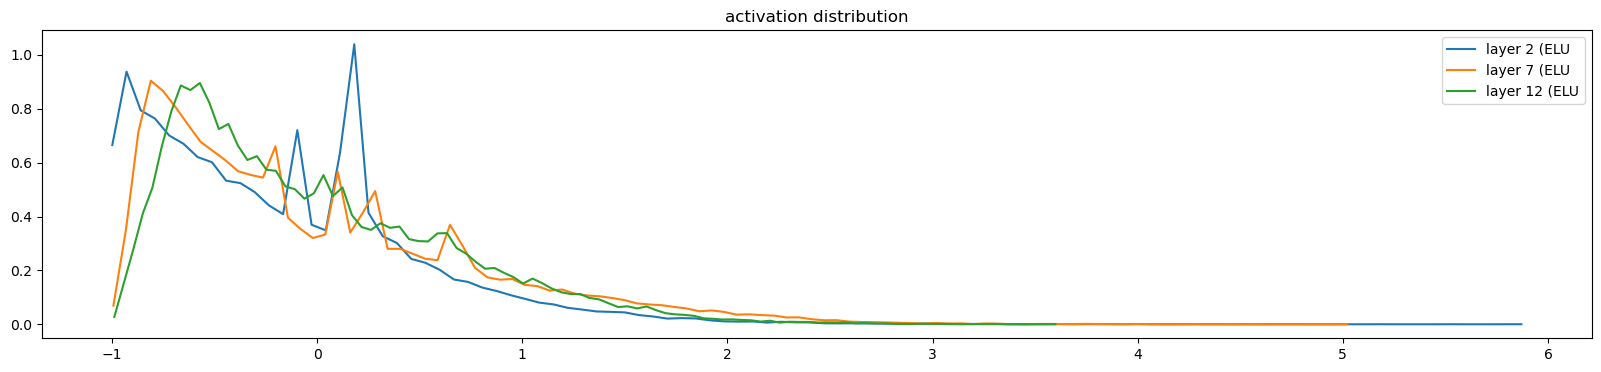

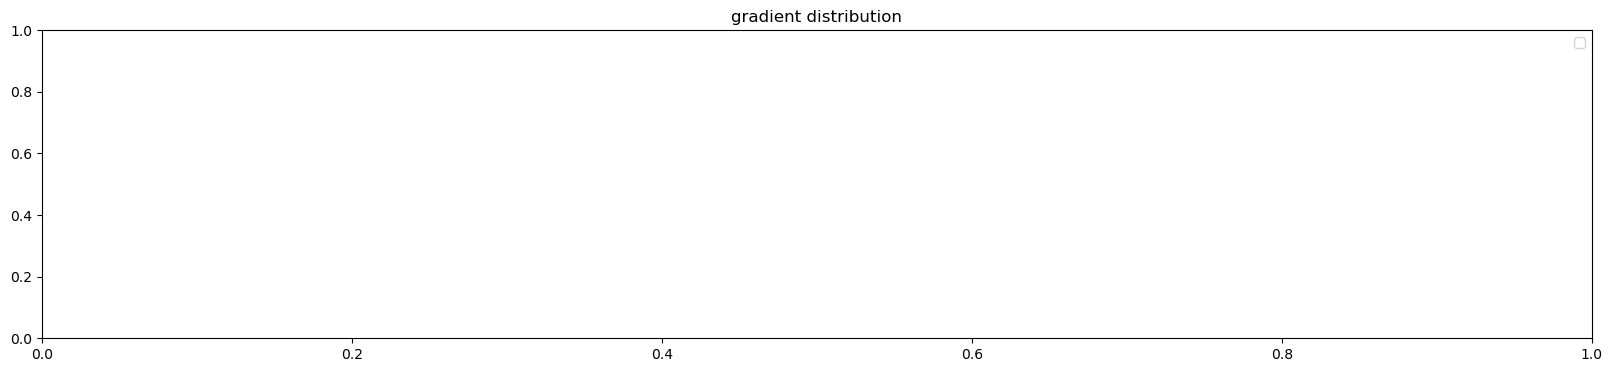

In [20]:
# ELU Activations and their gradients

plt.figure(figsize=(20, 4)); # width and height of the plot
legends = []
for i, layer in enumerate(model.eeg_encoder[:-1]): # note: exclude the output layer
    if isinstance(layer, (ELU)):
        t = layer.out
        print('layer %d (%10s):  mean  %+f, std %e, range [%e  %e]' % (i, layer.__class__.__name__, t.mean(), t.std(), t.min(), t.max()))
        print(t.shape)
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('activation distribution')



plt.figure(figsize=(20, 4)); # width and height of the plot
legends = []
for i, layer in enumerate(model.env_encoder[:-1]): # note: exclude the output layer
    if isinstance(layer, (ELU)):
        t = layer.out
        print('layer %d (%10s):  mean  %+f, std %e, range [%e  %e]' % (i, layer.__class__.__name__, t.mean(), t.std(), t.min(), t.max()))
        print(t.shape)
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('activation distribution')


plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.eeg_encoder[:-1]): # note: exclude the output layer
    if isinstance(layer, ELU):
        t = layer.out.grad
        print('layer %d (%10s):  mean  %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
    plt.title('gradient distribution')


plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.env_encoder[:-1]): # note: exclude the output layer
    if isinstance(layer, ELU):
        t = layer.out.grad
        print('layer %d (%10s):  mean  %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
    plt.title('gradient distribution')


In [ ]:
# Conv2d Activations and their gradients
if True:
    plt.figure(figsize=(20, 4)); # width and height of the plot
    legends = []
    for i, layer in enumerate(model.eeg_encoder[:-1]): # note: exclude the output layer
        if isinstance(layer, (Conv2d)):
            t = layer.out.to('cpu')
            print('layer %d (%10s):  mean  %+f, std %e, range [%e  %e]' % (i, layer.__class__.__name__, t.mean(), t.std(), t.min(), t.max()))
            print(t.shape)
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            #plt.xlim(-.1, .1)
            #plt.ylim(0, 1000)
            legends.append(f'layer {i} ({layer.__class__.__name__}')
        plt.legend(legends);
        plt.title('activation distribution')

    plt.figure(figsize=(20, 4)); # width and height of the plot
    legends = []
    for i, layer in enumerate(model.env_encoder[:-1]): # note: exclude the output layer
        if isinstance(layer, (Conv2d)):
            t = layer.out.to('cpu')
            print('layer %d (%10s):  mean  %+f, std %e, range [%e  %e]' % (i, layer.__class__.__name__, t.mean(), t.std(), t.min(), t.max()))
            print(t.shape)
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__}')
        plt.legend(legends);
        plt.title('activation distribution')


    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i, layer in enumerate(model.eeg_encoder[:-1]): # note: exclude the output layer
        if isinstance(layer, Conv2d):
            t = layer.out.grad
            print('layer %d (%10s):  mean  %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')
        plt.legend(legends);
        plt.title('gradient distribution')


    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i, layer in enumerate(model.env_encoder[:-1]): # note: exclude the output layer
        if isinstance(layer, Conv2d):
            t = layer.out.grad
            print('layer %d (%10s):  mean  %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')
        plt.legend(legends);
        plt.title('gradient distribution')



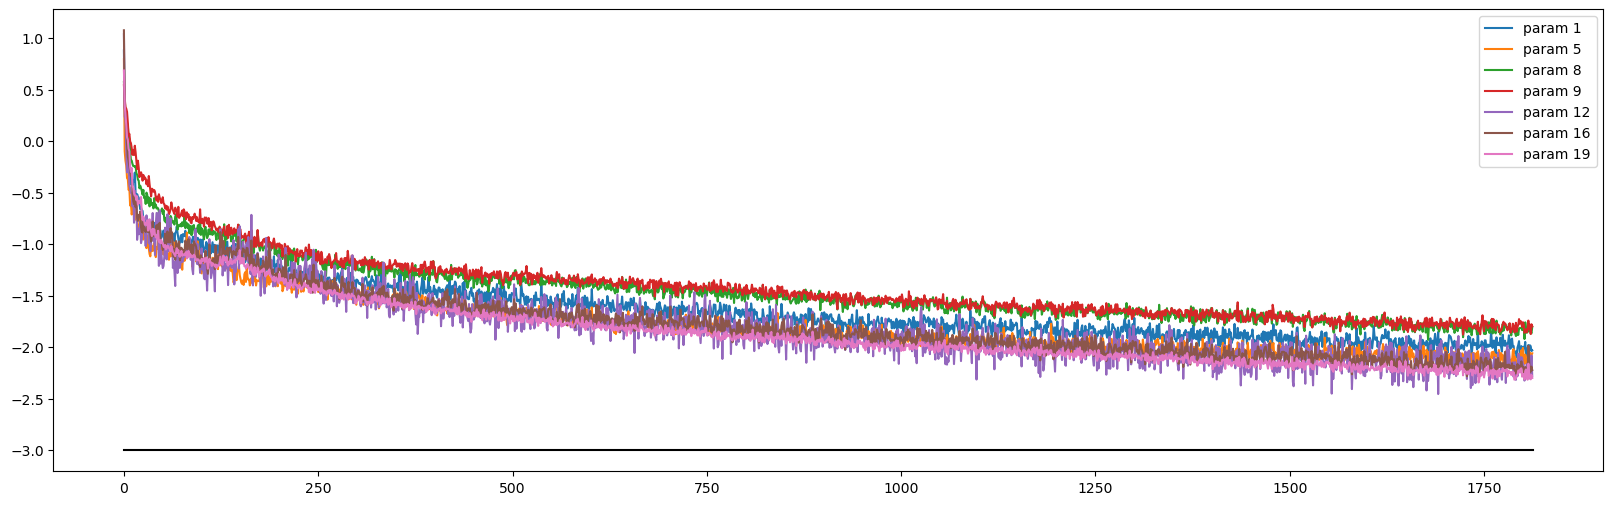

In [21]:
# Check the update / data ratio

plt.figure(figsize=(20, 6))
legends = []
for i, p in enumerate(model.parameters()):
    if p.ndim == 4:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these rations should be ~1e-3, indicate on plot.
plt.legend(legends);